In [1]:
from matplotlib import pyplot as plt
import numpy as np
import scipy.ndimage as ndimage
from collections import deque
from skimage.transform import resize
import sklearn.cluster
from skimage import draw
import math

import snake_functions as sf
#import importlib
#importlib.reload(sf)

Define Model functionality:

In [88]:
class deform_model():
    def __init__(self,n_points, center, radius, smooth_param):
        self.alpha = smooth_param[0]
        self.beta = smooth_param[1]
        th = np.arange(0,1,1/n_points)*(2*np.pi)
        self.snake = np.array([np.cos(th), np.sin(th)]).transpose()*radius + center
        self.normals = self.compute_normals()
        self.smooth_mat = sf.smooth_matrix(n_points, smooth_param[0], smooth_param[1])

    def compute_normals(self):
        a = np.zeros_like(self.snake)
        s_prev = np.roll(self.snake,  1, axis=0) # prev
        s_next = np.roll(self.snake, -1, axis=0) # next
        a[:,0] =   s_next[:,1] - s_prev[:,1]
        a[:,1] = -(s_next[:,0] - s_prev[:,0])
        a = a / np.linalg.norm(a, axis=1)[:,None]
        return a
    
    def read_values(self,img):
        idx_xy = self.snake.astype(int)
        return (img[idx_xy[:,0], idx_xy[:,1]])

    def set_forces(self, forces):
        self.force_vecs = forces[:,None] * self.normals
        
    def update(self, step_size):
        self.snake += self.force_vecs*step_size
        self.regularize()
        self.normals = self.compute_normals()
        
    def check_bounds(self, img_shape):
        # Prevent exceeding image boundaries:
        np.clip(self.snake[:,0], 0, img_shape[0]-1, out=self.snake[:,0])
        np.clip(self.snake[:,1], 0, img_shape[1]-1, out=self.snake[:,1])
        
    def regularize(self):
        self.snake[:,:] = self.smooth_mat.dot(self.snake)
        snakeT = sf.distribute_points(self.snake.T)
        snakeT = sf.remove_intersections(snakeT)
        self.snake[:,:] = snakeT.T

    def joints(self):
        return self.snake.shape[0]
        
    def length(self):
        return np.linalg.norm(
            self.snake - np.roll(self.snake,  1, axis=0)
         , axis=1).sum()

    def add_joints(self, n):
        p0 = model.snake[-1,]
        p1 = model.snake[0,]
        a = np.empty((n,2))
        for i in range(n):
            a[i] = p0 + i/n*(p1-p0)
        self.snake = np.concatenate((model.snake, a), axis=0)
        self.snake[:,:] = sf.distribute_points(self.snake.T).T
        self.normals = self.compute_normals()        
        self.smooth_mat = sf.smooth_matrix(self.snake.shape[0], self.alpha, self.beta)

    def center(self):
        return self.snake.mean(axis=0)

Create probability image:

In [3]:
def create_prob_image(img, mask, filter_size=10, return_probs=False):    
    all_unique = np.unique(img.flatten()) # array containing each different pixel value

    count_inside = np.zeros_like(all_unique)
    count_outside = np.zeros_like(all_unique)
    count_total = np.zeros_like(all_unique)
    for i,x in enumerate(all_unique):
        count_inside[i] = (img[mask]==x).sum()
        count_outside[i] = (img[~mask]==x).sum()
        count_total[i] = count_inside[i]+count_outside[i]
        
    omega_in = mask.sum()
    omega_out = img.size - omega_in
#    pixel_prc_in = count_inside/total_inside
#    pixel_prc_out = count_outside/total_outside
#    pixel_probs = pixel_prc_in / (pixel_prc_in+pixel_prc_out)
    
    pixel_probs = count_inside/(count_outside+1e-8)
    
    prob_img = np.zeros_like(img, dtype=float)
    for i,x in enumerate(all_unique):
        prob_img[img==x] = pixel_probs[i]
#    prob_img = ndimage.gaussian_filter(prob_img, sigma=(5, 5), order=0)
    prob_img = ndimage.median_filter(prob_img, size=filter_size)

    if return_probs: 
        return prob_img, omega_in, omega_out, pixel_probs
    else:
        return prob_img, omega_in, omega_out

Some visulization methods:

In [4]:
def colorize_prob_img(prob_img, channels=(1,0)):
    prob_img_color = np.zeros(prob_img.shape+(3,), dtype='uint8')
    prob_img_color[:,:,channels[0]] =  prob_img*(prob_img > 0) * 255
    prob_img_color[:,:,channels[1]] = -prob_img*(prob_img < 0) * 255
    return prob_img_color

In [5]:
def layout_dictionary(cluster_centers, rows, cols, patch_shape=(), color=False, highlight=None, spacing=3):
    if(patch_shape==()):
        s = int(np.sqrt(cluster_centers.shape[1]/(1+2*color)))
        patch_shape = (s,s)

    h = patch_shape[0]+spacing
    w = patch_shape[1]+spacing
    dict_img = np.zeros((rows*w + spacing, cols*w + spacing, 3), dtype='uint8')

    if(color):
        cluster_centers = cluster_centers.reshape(rows,cols,3,patch_shape[0],patch_shape[1])
        cluster_centers = np.moveaxis(cluster_centers, -3, -1) # move color axis to last dim, (r,c,3,ps,ps) -> (r,c,ps,ps,3)
    else:
        cluster_centers = cluster_centers.reshape(rows,cols,patch_shape[0],patch_shape[1])

    if(highlight is not None): highlight = highlight.reshape(rows,cols)

    for r in range(rows):
        for c in range(cols):
            y = spacing + r*h
            x = spacing + c*w
            if(highlight is not None):
                p = highlight[r,c]
                dict_img[y-1:y+patch_shape[0]+1, x-1:x+patch_shape[1]+1, :] = [-p*(p<0)*255, p*(p>0)*255, 0]
                
            if(color):
                dict_img[y:y+patch_shape[0], x:x+patch_shape[1], ] = cluster_centers[r,c,:,:,]
            else:
                dict_img[y:y+patch_shape[0], x:x+patch_shape[1], ] = cluster_centers[r,c,:,:,None]
    
    return dict_img

In [6]:
import cv2

def draw_snake(img_out, snake, color=(255,0,0)):
    snake = np.flip(snake,axis=1)
    pt0 = snake[-1,:].astype(int)
    for i in range(len(snake)):
        pt1 = snake[i,:].astype(int)
        img_out = cv2.line(img_out, tuple(pt0), tuple(pt1), color, 1)
        img_out = cv2.circle(img_out, tuple(pt1), 2, color, cv2.FILLED, 1)
        pt0 = pt1
    return img_out 

def draw_forces(img_out, snake, forces, color=(255,0,0)):
    snake = np.flip(snake,axis=1)
    forces = np.flip(forces,axis=1)
    for i in range(len(snake)):
        pt = snake[i,:]
        pt2 = snake[i,:] + forces[i,]
        img_out = cv2.arrowedLine(img_out, tuple(pt.astype(int)), tuple(pt2.astype(int)), color, 1)
    return img_out 

def vis_snake(img, snake, forces={}, wait=30, color=(255,0,0), title="snake"):
    if img.ndim==2:
        img_out = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    else:
        img_out = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    img_out = draw_snake(img_out, snake, color)
    if len(forces)>0:
        img_out = draw_forces(img_out, snake, forces, color=color)
    cv2.imshow(title, img_out)
    key = cv2.waitKey(wait)
    return key==27



In [8]:
def plot_snake(snake,col='blue',linetype='.-'):
    plt.plot(*zip(*np.flip(snake,axis=1)),linetype,linewidth=1,color=col)

Cluster image:

In [7]:
def im2col(A, BSZ, stepsize=1):
    # Parameters
    m,n = A.shape
    s0, s1 = A.strides
    nrows = m-BSZ[0]+1
    ncols = n-BSZ[1]+1
    shp = BSZ[0],BSZ[1],nrows,ncols
    strd = s0,s1,s0,s1

    out_view = np.lib.stride_tricks.as_strided(A, shape=shp, strides=strd)
    return out_view.reshape(BSZ[0]*BSZ[1],-1)[:,::stepsize]

def ndim2col(A, BSZ, stepsize=1):
    if(A.ndim == 2):
        return im2col(A, BSZ, stepsize)
    else:
        r,c,l = A.shape
        patches = np.zeros((l*BSZ[0]*BSZ[1],(r-BSZ[0]+1)*(c-BSZ[1]+1)))
        for i in range(l):
            patches[i*BSZ[0]*BSZ[1]:(i+1)*BSZ[0]*BSZ[1],:] = im2col(A[:,:,i],BSZ,stepsize)
        return patches

In [15]:
def prepare_image(img, clusters=100, sample_size=5000, patch_size=5):
    if(patch_size%2==0): raise ValueError('patch_size most be an odd integer')

    E = int(patch_size/2)
    patch_size = (patch_size, patch_size)
    features = ndim2col(img, patch_size).transpose()
#    print(features.shape)

    sample_idx = np.random.permutation(features.shape[0])[:sample_size]
    feature_sample = features[sample_idx,:]
    kmeans = sklearn.cluster.KMeans(n_clusters=clusters, verbose=False).fit(feature_sample)

    predicted_clusters = kmeans.predict(features)
    img = img[E:-E, E:-E] # crop image to match shapes
    cluster_img = predicted_clusters.reshape(img.shape[:2])
#    plt.imshow(cluster_img)

    return cluster_img, img, kmeans

Define deforming process:

In [89]:
def run_model(model, cluster_img, cluster_layout=None,
                step_size  = 2.5,
                iterations = 0,
                vizualize  = True,
                calc_probs_each = 2,
                max_joint_dist  = 10,
                verbose = False,
                step_size_end = 0.1,
                conv_check = 10,
                conv_factor = 5):
    
    conv = np.zeros((conv_check,3))

    i=0
    while(i<=iterations):
        if(i%calc_probs_each==0):
            mask = draw.polygon2mask(cluster_img.shape[:2], model.snake)
            prob_img, omega_in, omega_out, probs = create_prob_image(cluster_img, mask, filter_size=10, return_probs=True)
            if(vizualize):
                prob_img_color = colorize_prob_img(prob_img-0.5, channels=(1,2))

                dict_img = layout_dictionary(cluster_layout[0], cluster_layout[1], cluster_layout[2], color=True, highlight=probs-0.5)
                dict_img = ndimage.zoom(dict_img, (3, 3, 1), order=0)
                dict_img = cv2.cvtColor(dict_img,cv2.COLOR_RGB2BGR)

    #    model.set_forces(model.read_values(prob_img) - 0.5)
        model.set_forces(np.log(omega_out/omega_in * model.read_values(prob_img)+1e-8))

        if(vizualize):
        #    cv2.imshow("mask", mask.astype(float))
            cv2.imshow("color probs", prob_img_color)
            cv2.imshow("dictionary",dict_img)
        #    vis_snake(prob_img.astype('float32'), model.snake, 3*step_size*model.force_vecs, wait=1, title="Probability")

            if vis_snake(img, model.snake, wait=1, title="Original"): break # Break by pressing 'esc'

        model.update(step_size)
        model.check_bounds(cluster_img.shape[:2])

        # Extend snake by adding more joints if the average distance between joints
        # is greater than 'max_joint_dist'
        L = model.length()
        if(L / model.joints() > max_joint_dist):
            n = math.ceil(L/(max_joint_dist) - model.joints())
            model.add_joints(n)
            model.check_bounds(cluster_img.shape[:2])
            if(verbose): print("Extend to ", model.joints(), "joints")

        # Check convergence
        #  by watching the changes in center position and 'radius' over af period K, that is:
        #  chk = sqrt( (x[i] - x[i-k])^2 + (y[i] - y[i-k])^2 + (r[i] - r[i-k] )^2)
        #  for all k < K
        # When conv_check < conv_factor * step_size, the step_size is halved untill below 'step_size_end'
        c = model.center();
        tr = np.array([c[0],c[1],np.sqrt(L)])
        chk = np.linalg.norm(tr-conv, axis=1)
        if( (chk < conv_factor*step_size).all() ):
            step_size /= 2
            if(verbose): print("Conv check = ",np.round(chk[-1],3)," new stepsize = ", step_size)
            if(step_size < step_size_end): break;
        conv[1:,] = conv[:-1,]
        conv[0,] = tr

        if(iterations>0): i+=1

    cv2.destroyAllWindows()
    cv2.waitKey(1);

    return model

## Run Model

### Tiger

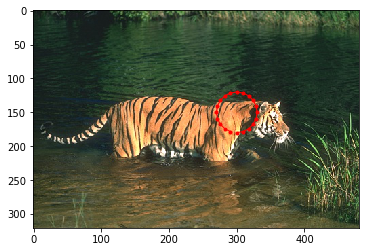

In [17]:
img = plt.imread("data/108073.jpg")
plt.imshow(img)
model = deform_model(n_points=20, center=(150,300), radius=30, smooth_param=(0,0.01))
plot_snake(model.snake, col='red')

In [18]:
cluster_img, img, kmeans = prepare_image(img, clusters=200, sample_size=5000, patch_size=5)

In [19]:
model = run_model(model, cluster_img, (kmeans.cluster_centers_,10,20))

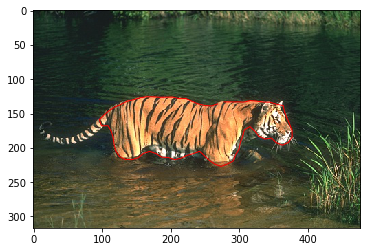

In [20]:
plt.imshow(img)
plot_snake(model.snake, col='red', linetype='-')

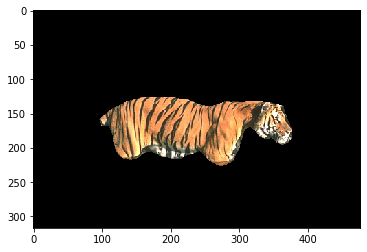

In [21]:
mask = draw.polygon2mask(cluster_img.shape[:2], model.snake)
output = img.copy()
output[~mask]=[0,0,0]
plt.imshow(output)

### Seastar

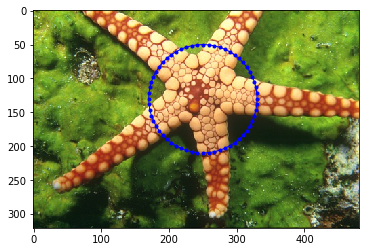

In [104]:
img = plt.imread("data/12003.jpg")
plt.imshow(img)
model = deform_model(n_points=60, center=(130,250), radius=80, smooth_param=(0.01,0.01))
plot_snake(model.snake)

In [65]:
cluster_img, img, kmeans = prepare_image(img, clusters=100, sample_size=5000, patch_size=5)

In [105]:
model = run_model(model, cluster_img, (kmeans.cluster_centers_,10,10), calc_probs_each=5, conv_check=20, verbose=True)

Extend to  66 joints
Extend to  71 joints
Extend to  79 joints
Extend to  83 joints
Extend to  92 joints
Extend to  101 joints
Extend to  105 joints
Extend to  109 joints
Extend to  111 joints
Extend to  115 joints
Extend to  118 joints
Extend to  121 joints
Extend to  123 joints
Extend to  131 joints
Extend to  133 joints
Extend to  136 joints
Extend to  137 joints
Extend to  145 joints
Conv check =  12.359  new stepsize =  1.25
Extend to  147 joints
Extend to  148 joints
Extend to  153 joints
Extend to  156 joints
Extend to  157 joints
Extend to  159 joints
Extend to  164 joints
Extend to  165 joints
Extend to  168 joints
Extend to  170 joints
Extend to  171 joints
Extend to  173 joints
Extend to  175 joints
Extend to  176 joints
Extend to  177 joints
Conv check =  1.656  new stepsize =  0.625
Conv check =  0.485  new stepsize =  0.3125
Conv check =  0.997  new stepsize =  0.15625
Conv check =  0.686  new stepsize =  0.078125


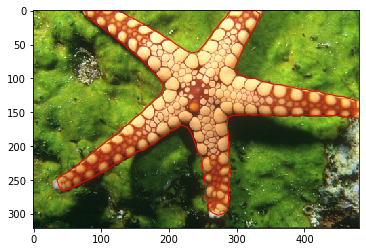

In [106]:
plt.imshow(img)
plot_snake(model.snake, col='red', linetype='-')

### Leopard

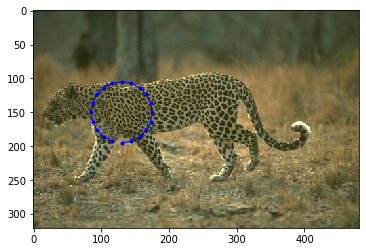

In [60]:
img = plt.imread("data/134052.jpg")
plt.imshow(img)
model = deform_model(n_points=20, center=(150,130), radius=45, smooth_param=(0,0.01))
plot_snake(model.snake)

In [42]:
cluster_img, img, kmeans = prepare_image(img, clusters=200, sample_size=5000, patch_size=5)

In [62]:
model = run_model(model, cluster_img, (kmeans.cluster_centers_,10,20), step_size=3, step_size_end=0.2)

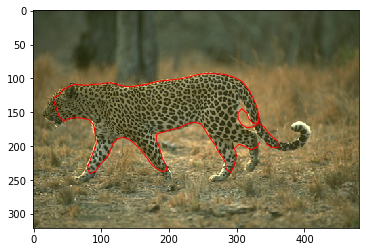

In [63]:
plt.imshow(img)
plot_snake(model.snake, col='red', linetype='-')